In [1]:
from datapreparation import load_and_prepare_data

train_ds, val_ds, test_ds, label_list, label2id, id2label = load_and_prepare_data()

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))
print("Labels:", label_list)
print("label2id:", label2id)

Label distribution (train):
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})
Train: 13249
Val: 1656
Test: 1657
Labels: ['Billing and Payments', 'Customer Service', 'General Inquiry', 'Sales and Pre-Sales', 'Technical Support']
label2id: {'Billing and Payments': 0, 'Customer Service': 1, 'General Inquiry': 2, 'Sales and Pre-Sales': 3, 'Technical Support': 4}


In [2]:
for i in range(2):
    print("\n" + "="*60)
    print("Example", i)
    print(train_ds["text"][i][:600])
    print("Label:", id2label[train_ds["label"][i]])


Example 0
Subject: Guidance on Investment Data Analytics

Body: Is it possible to receive guidance on optimizing investments through the use of data analytics and available tools and services? I am interested in learning how to make data-driven decisions.
Label: Customer Service

Example 1
Subject: None

Body: Dear customer support, the data analytics tool is failing to process investment data efficiently. The problem might be due to software compatibility issues. After updating the associated software devices, the issue still persists. We are currently investigating the data source integrity to identify the root cause. We are concerned about the potential impact on our business and would like assistance in resolving this matter as soon as possible. Please inform us of the next steps to be taken.
Label: Sales and Pre-Sales


In [3]:
import transformers, datasets
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)

transformers: 4.57.3
datasets: 4.4.2


In [4]:
import os

SAVE_DIR = "./saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving models to:", os.path.abspath(SAVE_DIR))

Saving models to: c:\Users\Mohammad Nasiri\OneDrive\Desktop\New folder\saved_models


Agent 1 — GPT-2 Prompting (Likelihood Scoring)

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print("Loaded:", model_name, "on", device)

Loaded: distilgpt2 on cuda


In [6]:
import torch
import torch.nn.functional as F

def build_prompt_base(email_text: str) -> str:
    return f"""You are an email routing assistant.
Choose the correct department for this email.

Email:
{email_text}

Department:"""

@torch.no_grad()
def score_label(prompt: str, label: str) -> float:
    prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    full_ids = tokenizer(prompt + " " + label, return_tensors="pt").input_ids.to(device)

    outputs = model(full_ids)
    logits = outputs.logits  # (1, seq_len, vocab_size)

    prompt_len = prompt_ids.shape[1]
    label_token_ids = full_ids[:, prompt_len:]

    relevant_logits = logits[:, prompt_len - 1 : -1, :]  # logits[t] predicts token t+1

    log_probs = F.log_softmax(relevant_logits, dim=-1)

    token_log_probs = torch.gather(
        log_probs, dim=-1, index=label_token_ids.unsqueeze(-1)
    ).squeeze(-1)

    return float(token_log_probs.sum().item())


def predict_label_by_scoring(email_text: str):
    prompt = build_prompt_base(email_text)

    scores = {}
    for lab in label_list:  
        scores[lab] = score_label(prompt, lab)

    best_label = max(scores, key=scores.get)
    return best_label, scores

In [7]:
pred, scores = predict_label_by_scoring(test_ds["text"][0])
print("PREDICTED:", pred)
print("TRUE:", id2label[test_ds["label"][0]])
print("\nScores:")
for k, v in sorted(scores.items(), key=lambda x: -x[1]):
    print(f"{k:20s}  {v:.2f}")

PREDICTED: Customer Service
TRUE: Customer Service

Scores:
Customer Service      -9.03
Technical Support     -10.16
General Inquiry       -15.97
Sales and Pre-Sales   -22.87
Billing and Payments  -23.27


In [8]:
import time

def evaluate_agent1_scoring(dataset, n=100):
    """
    Agent 1 evaluation (prompting + likelihood scoring).
    If n is None, evaluate on the full dataset.
    """
    start = time.time()
    correct = 0

    N = len(dataset) if n is None else n

    for i in range(N):
        text = dataset["text"][i]
        true_id = dataset["label"][i]
        true_label = id2label[true_id]

        pred_label, _ = predict_label_by_scoring(text)

        if pred_label == true_label:
            correct += 1

        if (i + 1) % 10 == 0 and N <= 200:
            print(f"Done {i+1}/{N}")
        elif (i + 1) % 200 == 0 and N > 200:
            print(f"Done {i+1}/{N}")

    acc = correct / N
    elapsed = time.time() - start
    return acc, elapsed


# Quick check (100 samples) 
acc100, time100 = evaluate_agent1_scoring(test_ds, n=100)
print("\nAgent 1 (distilgpt2 scoring) accuracy@100:", round(acc100, 4))
print("Time for 100:", round(time100, 2), "seconds")

Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100
Done 100/100

Agent 1 (distilgpt2 scoring) accuracy@100: 0.33
Time for 100: 2.8 seconds


In [9]:
import os, psutil

process = psutil.Process(os.getpid())

def ram_mb():
    return process.memory_info().rss / (1024**2)

print("Current RAM usage (MB):", round(ram_mb(), 2))

Current RAM usage (MB): 1015.79


In [10]:
start_ram_agent1 = ram_mb()  

acc_all, time_all = evaluate_agent1_scoring(test_ds, n=len(test_ds["text"]))

print("\nAgent 1 (distilgpt2 scoring) accuracy@ALL:", round(acc_all, 4))
print("Time for ALL:", round(time_all, 2), "seconds")
print("Test size:", len(test_ds["text"]))

Done 200/1657
Done 400/1657
Done 600/1657
Done 800/1657
Done 1000/1657
Done 1200/1657
Done 1400/1657
Done 1600/1657

Agent 1 (distilgpt2 scoring) accuracy@ALL: 0.3126
Time for ALL: 45.01 seconds
Test size: 1657


In [11]:
agent1_ram = ram_mb() - start_ram_agent1

results = []

results.append({
    "method": "DistilGPT2 + prompting",
    "model": "distilgpt2 (frozen)",
    "accuracy": acc_all,
    "time_seconds": time_all,
    "ram_mb": agent1_ram
})

results

[{'method': 'DistilGPT2 + prompting',
  'model': 'distilgpt2 (frozen)',
  'accuracy': 0.31261315630657815,
  'time_seconds': 45.009963274002075,
  'ram_mb': 2.7265625}]

Agent 2 — GPT-2 Fine-Tuning with LoRA

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

gpt2_model_name = "distilgpt2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

gpt2_base = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
gpt2_base.to(device)

print("Loaded:", gpt2_model_name, "on", device)

Loaded: distilgpt2 on cuda


In [13]:
def make_gpt2_sft_text(email_text, label_id):
    label = id2label[label_id]
    return f"""You are an email routing assistant.
Choose the correct department for this email.

Email:
{email_text}

Department: {label}"""

train_sft_texts = [
    make_gpt2_sft_text(t, y)
    for t, y in zip(train_ds["text"], train_ds["label"])
]

val_sft_texts = [
    make_gpt2_sft_text(t, y)
    for t, y in zip(val_ds["text"], val_ds["label"])
]

print(train_sft_texts[0][:400])

You are an email routing assistant.
Choose the correct department for this email.

Email:
Subject: Guidance on Investment Data Analytics

Body: Is it possible to receive guidance on optimizing investments through the use of data analytics and available tools and services? I am interested in learning how to make data-driven decisions.

Department: Customer Service


In [14]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

gpt2_lora = get_peft_model(gpt2_base, lora_config)
gpt2_lora.print_trainable_parameters()

trainable params: 405,504 || all params: 82,318,080 || trainable%: 0.4926


p:\MiniConda\envs\nlp-llm-project\lib\site-packages\peft\tuners\lora\layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [15]:
from datasets import Dataset

# Supervised fine-tuning datasets, text already contains instruction + label
train_sft = Dataset.from_dict({"text": train_sft_texts})
val_sft   = Dataset.from_dict({"text": val_sft_texts})

print(train_sft)

Dataset({
    features: ['text'],
    num_rows: 13249
})


In [16]:
def tokenize_gpt2(batch):
    tok = gpt2_tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    tok["labels"] = tok["input_ids"].copy()
    return tok

train_sft_tok = train_sft.map(tokenize_gpt2, batched=True, remove_columns=["text"])
val_sft_tok   = val_sft.map(tokenize_gpt2, batched=True, remove_columns=["text"])

cols = ["input_ids", "attention_mask", "labels"]
train_sft_tok.set_format(type="torch", columns=cols)
val_sft_tok.set_format(type="torch", columns=cols)

print("Tokenization for GPT-2 done")

Map:   0%|          | 0/13249 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Tokenization for GPT-2 done


In [17]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=gpt2_tokenizer,
    mlm=False
)

In [18]:
from transformers import Trainer, TrainingArguments
import time, os, psutil

process = psutil.Process(os.getpid())

def ram_mb():
    return process.memory_info().rss / (1024**2)

start_ram_lora = ram_mb()
start_time_lora = time.time()


try:
    training_args_lora = TrainingArguments(
        output_dir="./distilgpt2_lora_router",
        evaluation_strategy="epoch",   
        save_strategy="no",
        learning_rate=2e-4,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
        num_train_epochs=1,
        logging_steps=50,
        report_to="none"
    )
except TypeError:
    training_args_lora = TrainingArguments(
        output_dir="./distilgpt2_lora_router",
        eval_strategy="epoch",       
        save_strategy="no",
        learning_rate=2e-4,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
        num_train_epochs=1,
        logging_steps=50,
        report_to="none"
    )

trainer_lora = Trainer(
    model=gpt2_lora,
    args=training_args_lora,
    train_dataset=train_sft_tok,
    eval_dataset=val_sft_tok,
    data_collator=data_collator,
    tokenizer=gpt2_tokenizer
)

trainer_lora.train()

AGENT2_DIR = os.path.join(SAVE_DIR, "agent2_distilgpt2_lora")
gpt2_lora.save_pretrained(AGENT2_DIR)       
gpt2_tokenizer.save_pretrained(AGENT2_DIR)  
print("✅ Saved Agent 2 (LoRA adapter) to:", AGENT2_DIR)


with open(os.path.join(AGENT2_DIR, "base_model_name.txt"), "w") as f:
    f.write("distilgpt2\n")


end_time_lora = time.time()
end_ram_lora = ram_mb()

agent2_time = end_time_lora - start_time_lora
agent2_ram = end_ram_lora - start_ram_lora

print("LoRA training done")
print("Time (train+eval):", round(agent2_time, 2), "seconds")
print("RAM increase (MB):", round(agent2_ram, 2))


C:\Users\Mohammad Nasiri\AppData\Local\Temp\ipykernel_33192\4277414823.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,1.724900,1.649407


✅ Saved Agent 2 (LoRA adapter) to: ./saved_models\agent2_distilgpt2_lora
LoRA training done
Time (train+eval): 280.01 seconds
RAM increase (MB): 247.95


In [19]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def score_label_lora(prompt: str, label: str) -> float:
    prompt_ids = gpt2_tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    full_ids = gpt2_tokenizer(prompt + " " + label, return_tensors="pt").input_ids.to(device)

    outputs = gpt2_lora(full_ids)
    logits = outputs.logits

    prompt_len = prompt_ids.shape[1]
    label_token_ids = full_ids[:, prompt_len:]

    relevant_logits = logits[:, prompt_len - 1 : -1, :]
    log_probs = F.log_softmax(relevant_logits, dim=-1)

    token_log_probs = torch.gather(
        log_probs, dim=-1, index=label_token_ids.unsqueeze(-1)
    ).squeeze(-1)

    return float(token_log_probs.sum().item())


def predict_label_by_scoring_lora(email_text: str):
    prompt = build_prompt_base(email_text)  
    scores = {lab: score_label_lora(prompt, lab) for lab in label_list}  
    best_label = max(scores, key=scores.get)
    return best_label, scores


In [20]:
pred, scores = predict_label_by_scoring_lora(test_ds["text"][0])
print("PREDICTED:", pred)
print("TRUE:", id2label[test_ds["label"][0]])
for k, v in sorted(scores.items(), key=lambda x: -x[1]):
    print(f"{k:20s}  {v:.2f}")

PREDICTED: Technical Support
TRUE: Customer Service
Technical Support     -0.62
Customer Service      -0.97
Billing and Payments  -3.31
Sales and Pre-Sales   -3.78
General Inquiry       -4.57


In [21]:
import time

def evaluate_agent2_lora(dataset):
    start = time.time()
    correct = 0
    n = len(dataset)

    for i in range(n):
        text = dataset["text"][i]
        true_label = id2label[dataset["label"][i]]

        pred_label, _ = predict_label_by_scoring_lora(text)
        if pred_label == true_label:
            correct += 1

        if (i + 1) % 200 == 0:
            print(f"Done {i+1}/{n}")

    acc = correct / n
    elapsed = time.time() - start
    return acc, elapsed


agent2_acc, agent2_eval_time = evaluate_agent2_lora(test_ds)
print("\nAgent 2 (LoRA distilgpt2) test accuracy:", round(agent2_acc, 4))
print("Agent 2 eval time:", round(agent2_eval_time, 2), "seconds")
print("RAM now (MB):", round(ram_mb(), 2))

Done 200/1657
Done 400/1657
Done 600/1657
Done 800/1657
Done 1000/1657
Done 1200/1657
Done 1400/1657
Done 1600/1657

Agent 2 (LoRA distilgpt2) test accuracy: 0.6373
Agent 2 eval time: 75.04 seconds
RAM now (MB): 1449.35


In [22]:
agent2_total_time = (end_time_lora - start_time_lora) + agent2_eval_time

results.append({
    "method": "DistilGPT2 + fine-tuning (LoRA)",
    "model": "distilgpt2 + LoRA",
    "accuracy": agent2_acc,
    "time_seconds": agent2_total_time,
    "ram_mb": agent2_ram   
})

results

[{'method': 'DistilGPT2 + prompting',
  'model': 'distilgpt2 (frozen)',
  'accuracy': 0.31261315630657815,
  'time_seconds': 45.009963274002075,
  'ram_mb': 2.7265625},
 {'method': 'DistilGPT2 + fine-tuning (LoRA)',
  'model': 'distilgpt2 + LoRA',
  'accuracy': 0.6372963186481593,
  'time_seconds': 355.05138993263245,
  'ram_mb': 247.9453125}]

Agent 3 — DistilBERT Discriminative Classifier

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

bert_model_name = "distilbert-base-uncased"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

print("Loaded:", bert_model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded: distilbert-base-uncased


In [24]:
def tokenize_batch(batch):
    return bert_tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_tok = train_ds.map(tokenize_batch, batched=True)
val_tok   = val_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

print("Tokenization done")

Tokenization done


In [25]:
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    return {"accuracy": acc}

In [26]:
from transformers import TrainingArguments, Trainer
import time, os, psutil

process = psutil.Process(os.getpid())

def ram_mb():
    return process.memory_info().rss / (1024**2)

start_ram = ram_mb()
start_time = time.time()


try:
    training_args = TrainingArguments(
        output_dir="./distilbert_email_router",
        evaluation_strategy="epoch",   
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none"
    )
except TypeError:
    training_args = TrainingArguments(
        output_dir="./distilbert_email_router",
        eval_strategy="epoch",         
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none"
    )

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)

print("Trainer ready")

C:\Users\Mohammad Nasiri\AppData\Local\Temp\ipykernel_33192\191169848.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready


In [27]:
trainer.train()
print("Training done")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.939900,0.873652,0.654589


Training done


In [28]:
AGENT3_DIR = os.path.join(SAVE_DIR, "agent3_distilbert")
trainer.save_model(AGENT3_DIR)            
bert_tokenizer.save_pretrained(AGENT3_DIR)  
print(" Saved Agent 3 to:", AGENT3_DIR)

 Saved Agent 3 to: ./saved_models\agent3_distilbert


In [29]:
test_metrics = trainer.evaluate(test_tok)
end_time = time.time()
end_ram = ram_mb()

agent3_acc = test_metrics["eval_accuracy"]
agent3_time = end_time - start_time
agent3_ram = end_ram - start_ram 

print("Agent 3 test accuracy:", round(agent3_acc, 4))
print("Agent 3 total time (train+eval):", round(agent3_time, 2), "seconds")
print("Agent 3 RAM increase (MB):", round(agent3_ram, 2))

Agent 3 test accuracy: 0.6807
Agent 3 total time (train+eval): 195.03 seconds
Agent 3 RAM increase (MB): 128.01


In [30]:
results.append({
    "method": "DistilBERT + classifier",
    "model": "distilbert-base-uncased",
    "accuracy": agent3_acc,
    "time_seconds": agent3_time,
    "ram_mb": agent3_ram
})

results

[{'method': 'DistilGPT2 + prompting',
  'model': 'distilgpt2 (frozen)',
  'accuracy': 0.31261315630657815,
  'time_seconds': 45.009963274002075,
  'ram_mb': 2.7265625},
 {'method': 'DistilGPT2 + fine-tuning (LoRA)',
  'model': 'distilgpt2 + LoRA',
  'accuracy': 0.6372963186481593,
  'time_seconds': 355.05138993263245,
  'ram_mb': 247.9453125},
 {'method': 'DistilBERT + classifier',
  'model': 'distilbert-base-uncased',
  'accuracy': 0.6807483403741702,
  'time_seconds': 195.02772736549377,
  'ram_mb': 128.01171875}]

Results and Comparison

In [31]:
import os

print("=== Saved models content ===")
for root, dirs, files in os.walk(SAVE_DIR):
    level = root.replace(SAVE_DIR, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  - {f}")

=== Saved models content ===
saved_models/
  agent2_distilgpt2_lora/
    - adapter_config.json
    - adapter_model.safetensors
    - base_model_name.txt
    - merges.txt
    - README.md
    - special_tokens_map.json
    - tokenizer.json
    - tokenizer_config.json
    - vocab.json
  agent3_distilbert/
    - config.json
    - model.safetensors
    - special_tokens_map.json
    - tokenizer.json
    - tokenizer_config.json
    - training_args.bin
    - vocab.txt


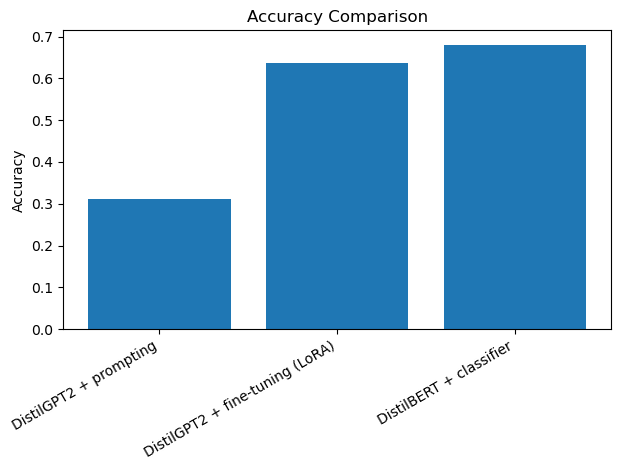

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)
plt.figure()
plt.bar(df_results["method"], df_results["accuracy"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.tight_layout()
plt.show()

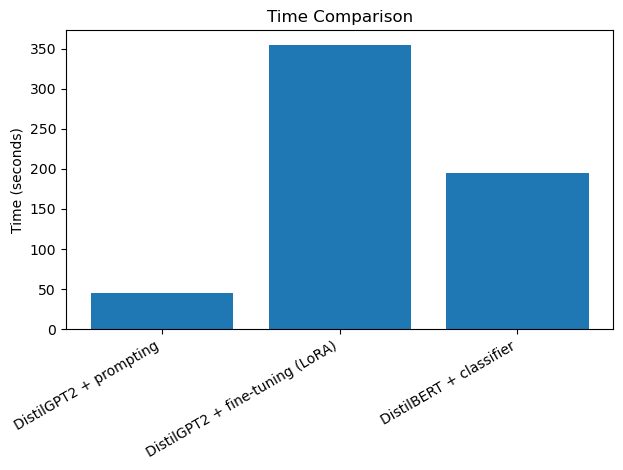

In [34]:
plt.figure()
plt.bar(df_results["method"], df_results["time_seconds"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Time (seconds)")
plt.title("Time Comparison")
plt.tight_layout()
plt.show()

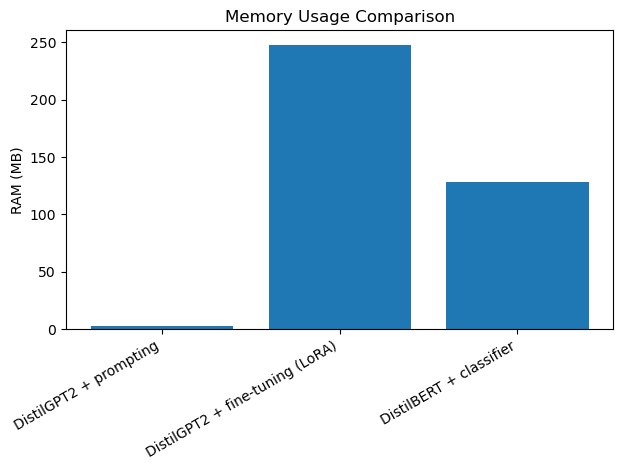

In [35]:
plt.figure()
plt.bar(df_results["method"], df_results["ram_mb"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("RAM (MB)")
plt.title("Memory Usage Comparison")
plt.tight_layout()
plt.show()

In [36]:
df_results_pretty = df_results.copy()

name_map = {
    "DistilGPT2 + prompting": "DistilGPT2 + prompting",
    "DistilBERT + classifier": "DistilBERT + classifier",
    "DistilGPT2 + fine-tuning (LoRA)": "DistilGPT2 + fine-tuning (LoRA)",
}

df_results_pretty["method"] = df_results_pretty["method"].map(name_map)

df_results_pretty

,method,model,accuracy,time_seconds,ram_mb
0,DistilGPT2 + prompting,distilgpt2 (frozen),0.312613,45.009963,2.726562
1,DistilGPT2 + fine-tuning (LoRA),distilgpt2 + LoRA,0.637296,355.051390,247.945312
2,DistilBERT + classifier,distilbert-base-uncased,0.680748,195.027727,128.011719
